# Package requirements
#### opencv-python, numpy, Pillow, matplotlib, scikit-image

In [1]:
# run this line to install package into project environment
!pip3 install opencv-python numpy Pillow matplotlib scikit-image imutils

#### Import packages

In [2]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from skimage import color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import disk
from skimage.util import img_as_ubyte
from skimage.io import imread
import skimage.io as sko
import math

#Enhance image contrast for later using
image = Image.open('abc.png')

contrast = ImageEnhance.Contrast(image)
contrast = contrast.enhance(1.5)
contrast.save('contrast.png')


In [3]:
# import image module 
from IPython.display import Image as Im 
  
# get the image 
Im(url="abc.png", width=300, height=300)

In [4]:
# Processed image
Im(url="abc_step5_enhancing_contrast.png", width=300, height=300)

# Approach to the problem

##### To keep this approach easy to follow and understand, I decide devide problem into steps, each step tackle with each areas of interests
1. Understand the Problem
    - research to have certan level of the problem
2. Divide areas of interests into subs(steps)
    - Concentrate on solving one sub at a time
    - more manageable
    - a distinct way to solve of each sub

3. Iterate and Refine
    - revisit and refine your solution.  
    - improvements and adjustments as we gain a deeper understanding.
    - able to write a full function to repeatedly using

4. Test and Validate
    - Test the complete solution to verify that it meets the requirements and effectively addresses the initial the problem

5. Optimize
    - Look for ways to optimize your solution
    - This could involve improving efficiency, reducing complexity, or enhancing overall performance.

6. Document
    - Document your solution, including the rationale behind your decisions and any insights gained during the problem-solving process

In [5]:
def scale_contour(cnt, scale):
    """
    Function scale up or down the contour size
    """
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    cnt_norm = cnt - [cx, cy]
    cnt_scaled = cnt_norm * scale
    cnt_scaled = cnt_scaled + [cx, cy]
    cnt_scaled = cnt_scaled.astype(np.int32)

    return cnt_scaled

def get_xy(contour):
    """
    get x and y coordinates on 2d x and y
    """
    moments = cv2.moments(contour)
    centroid_x = 0
    centroid_y = 0
    if moments['m00'] != 0:
        centroid_x = int(moments['m10'] / moments['m00'])
        centroid_y = int(moments['m01'] / moments['m00'])

    return (centroid_x, centroid_y)


def distance_xy(xy_A, xy_B):
    """
    Euclidean distance between two points on 2 dimensions
    """
    return math.hypot(xy_A[0]-xy_B[0], xy_A[1]-xy_B[1])


# STEP 1: The firing pin drag (light blue)

- I used Opencv package to detect area of firing pin drag, called contour
- cv2.addWeighted to transparent color to see texture of cartridge surface

In [6]:
# Read the original image
img = cv2.imread('abc.png')
# Convert image into gray scale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Blurring image
img_gray = cv2.blur(img_gray, (3,3))
# apply binary thresholding
ret, thresh = cv2.threshold(img_gray, 78, 255, cv2.THRESH_BINARY_INV)
#Closing contour
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (14,9))
close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
# apply binary thresholdin again
ret, thresh = cv2.threshold(close, 80, 255, cv2.THRESH_BINARY_INV)
#Closing contour again
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (14,9))
close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

#Detect contours
contours, hierarchy = cv2.findContours(image=close, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
# Create a blank image with the same dimensions as the original image
filled_img = np.zeros(img.shape[:2], dtype=np.uint8)
# Fill the outer contour with white color
cv2.drawContours(filled_img, contours, -1, 255, cv2.FILLED)

# Iterate over the contours and their hierarchies
for i, contour in enumerate(contours):
    # Check if the contour has no child
    if hierarchy[0][i][2] < 0:
        # If contour has no child, fill the contour with black color
        cv2.drawContours(filled_img, [contour], -1, 0, cv2.FILLED)

In [7]:
step1_image = img.copy()
#step1_image = cv2.cvtColor(step1_image, cv2.COLOR_GRAY2BGR)
image_copy = step1_image.copy()
#image_output = img.copy()
#select center contour
selected_cont = []
for cont in contours:
    area = cv2.contourArea(cont)
    if area > 150000 and area < 200000:
       cont_resized = scale_contour(cont, 0.96)
       selected_cont.append(cont_resized)
# draw contours on the image
cv2.drawContours(image=image_copy, contours=selected_cont, contourIdx=-1, color=(200,130,0), thickness=-1)

#transparent light blue color
image_saved = cv2.addWeighted(step1_image, 0.5, image_copy, 0.5, 0)



##### press any key to go to next image until exit window

In [8]:
#visualize the binary image
# press any key to go to next image until exit window
cv2.imshow('abc_step1_thresh', thresh)
cv2.waitKey(0)
cv2.imwrite('abc_step1_thresh.jpg', thresh)
cv2.imshow('abc_step1_closing_contour', close)
cv2.waitKey(0)
cv2.imwrite('abc_step1_closing_contour.jpg', close)
cv2.imshow('abc_step1_closing_contour2', close)
cv2.waitKey(0)
cv2.imwrite('abc_step1_closing_contour2.jpg', close)
cv2.imshow('Filled Regions', filled_img)
cv2.imwrite('abc_step1_inverted_regions.jpg', filled_img)
cv2.waitKey(0)
cv2.imshow('abc_step1_finished', image_saved)
cv2.waitKey(0)
cv2.imwrite('abc_step1_finished.jpg', image_saved)
cv2.destroyAllWindows()


# STEP 2: The firing pin impression (purple)

- Used cv2.canny to detect edges of pin impression
- Using cv2.hough_circle to detect alike circle shapes in image based on edges detection
- Than find the centroid of detected alike circle to draw a pefect circle
- cv2.addWeighted to transparent color to see texture of cartridge surface

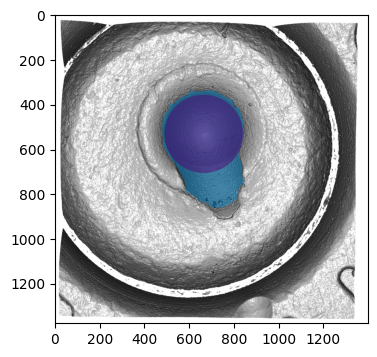

In [9]:
# reading image created from step 1
sk_image = imread('abc_step1_inverted_regions.jpg')
orig_image = imread('abc_step1_finished.jpg')
orig_image_cp = orig_image.copy()
sk_image_copy = sk_image.copy()
# read image into ubyte and use canny detect edges
image = img_as_ubyte(sk_image_copy)
edges = canny(image, sigma=1, low_threshold=10, high_threshold=20)


# Detect two radii
hough_radii = np.arange(200, 300, 2)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 1 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=1)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = disk((center_y, center_x), radius - radius/8)
    orig_image_cp[circy, circx] = (83,0,114)

#transparent center colour
image_saved = cv2.addWeighted(orig_image_cp, 0.5, orig_image, 0.5, 1)

ax.imshow(image_saved, cmap=plt.cm.gray)
sko.imsave('abc_step2_finished.png', image_saved)
plt.show()

# STEP 3: The direction of the firing pin drag (blue arrow)
- Used two centroid to draw blue arrow
- Added length to arrow using tuble of x and y coordinates
- cv2.addWeighted to transparent color to see texture of cartridge surface

In [10]:
# get the centroid of pin impresion from Step 2
impresion_centroid = (cx[0], cy[0])
# Get the centroid of the pin drag from Step 1
drag_centroid = get_xy(selected_cont[0])
# add length of line
drag_centroid = tuple(map(sum, zip(drag_centroid, (60,200))))

In [11]:
# Reading an image in from STEP 2
step3_image = cv2.imread('abc_step2_finished.png') 

# represents the top left corner of image 
start_point = impresion_centroid

# End coordinate 
end_point = drag_centroid

# Green color in BGR 
color = (255, 0, 0)

# Line thickness of 9 px 
thickness = 9

# Using cv2.arrowedLine() method draw a diagonal green arrow line
step3_image = cv2.arrowedLine(step3_image, start_point, end_point, color, thickness, tipLength = 0.1) 

# Displaying the image 
cv2.imshow('Image step 3', step3_image)
cv2.waitKey(0)
cv2.imwrite('abc_step3_finished.png', step3_image)
cv2.destroyAllWindows()

# STEP 4: The breech-face impression (red)
- Used cv2.findContours to detect breach-face impression contour only
- also use different params for easier contour detection
- cv2.addWeighted to transparent color to see texture of cartridge surface

In [12]:
import cv2
 
# Read the original image
img = cv2.imread('abc.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# apply binary thresholding
ret, thresh = cv2.threshold(img_gray, 155, 255, cv2.THRESH_BINARY_INV)

#Close contour
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (14,9))
close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=5)

# apply binary thresholdin again
ret, thresh = cv2.threshold(close, 155, 255, cv2.THRESH_BINARY_INV)

#Close contour again
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (14,9))
close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=5)

# detect the contours on the binary image using cv2.RETR_EXTERNAL
contours, hierarchy = cv2.findContours(image=close, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

In [13]:
# Create a blank image with the same dimensions as the original image
filled_img = np.zeros(img.shape[:2], dtype=np.uint8)
# Fill the outer contour with white color
cv2.drawContours(filled_img, contours, -1, 255, cv2.FILLED)
# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv2.findContours(image=close, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

# Iterate over the contours and their hierarchies
for i, contour in enumerate(contours):
    # Check if the contour has no child
    if hierarchy[0][i][2] < 0:
        # If contour has no child, fill the contour with black color
        cv2.drawContours(filled_img, [contour], -1, 0, cv2.FILLED)

In [14]:
# reading step3 finished image and add breech impression
image_copy = cv2.imread('abc_step3_finished.png')
image_output = img.copy()
# detect the contours on the filledbinary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv2.findContours(image=filled_img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
# draw contours on the image
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0,0,255), thickness=-1)

#transparent red color
image_saved = cv2.addWeighted(image_copy, 0.7, image_output, 0.3, 1)

In [15]:
#show image and save
cv2.imshow('Filled Regions', filled_img)
cv2.imwrite('abc_step4_filled_regions.jpg', filled_img)
cv2.waitKey(0)
cv2.imshow('orignal image', image_copy)
cv2.waitKey(0)
cv2.imshow('abc_step4_finished', image_saved)
cv2.waitKey(0)
cv2.imwrite('abc_step4_finished.png', image_saved)
cv2.destroyAllWindows()

# STEP 5: The aperture shear (green)
- Same techniques with different setting params
- based on canculated centroids distances to remove noise contours detected, keep only aperture shear contours
- cv2.addWeighted to transparent color to see texture of cartridge surface
- Enhanced image

In [16]:
# Read the original image contrast created at begin
img = cv2.imread('contrast.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# apply blur and binary thresholding
blur = cv2.GaussianBlur(img_gray, (13,13), 0)
ret, thresh = cv2.threshold(blur, 180, 255, cv2.THRESH_BINARY)
#Close contour
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
# Apply Canny edge detection
edges = cv2.Canny(close, 55, 200)
# Find contours in the edge-detected image
contours, hierarchy = cv2.findContours(edges, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

In [17]:
# Use the pin impresion centroid
impresion_centroid = impresion_centroid

# reading original image
img_copy = cv2.imread('abc.png')

for i, contour in enumerate(contours):

    # Compute straight bounding rectangle
    x,y,w,h = cv2.boundingRect(contour)

    # compute rotated rectangle to get minium area
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    #convert box
    box = np.intp(box)
    # If contourArea and Hierarchy to filter noise contours
    if cv2.contourArea(box) >= 2000 and cv2.contourArea(box) <= 15000 and\
                    cv2.contourArea(contour) > 100 and hierarchy[0][i][2] < 0:
        # get contour centroid
        cnt_centroid = get_xy(contour)
        # get distance to image centroid
        dist = distance_xy(cnt_centroid, impresion_centroid)
        #dist_list.append(dist)
        if dist > 200 and dist < 400:
            #scale down rectangle and draw rect and contour
            cv2.drawContours(img_copy, [contour], 0, color=(10,93,0), thickness=29)

step4_image = cv2.imread('abc_step4_finished.png', cv2.IMREAD_COLOR)
#transparent red color
image_saved = cv2.addWeighted(step4_image, 0.7, img_copy, 0.4, 0)

In [18]:
#showing image
cv2.imshow('Step 5 finished', image_saved)
cv2.waitKey(0)
cv2.imwrite('abc_step5_finished.png', image_saved)
cv2.destroyAllWindows()

In [19]:
#Enhance image contrast for better view
image = Image.open('abc_step5_finished.png')

contrast = ImageEnhance.Contrast(image)
contrast = contrast.enhance(1.3)
contrast.save('abc_step5_enhancing_contrast.png')

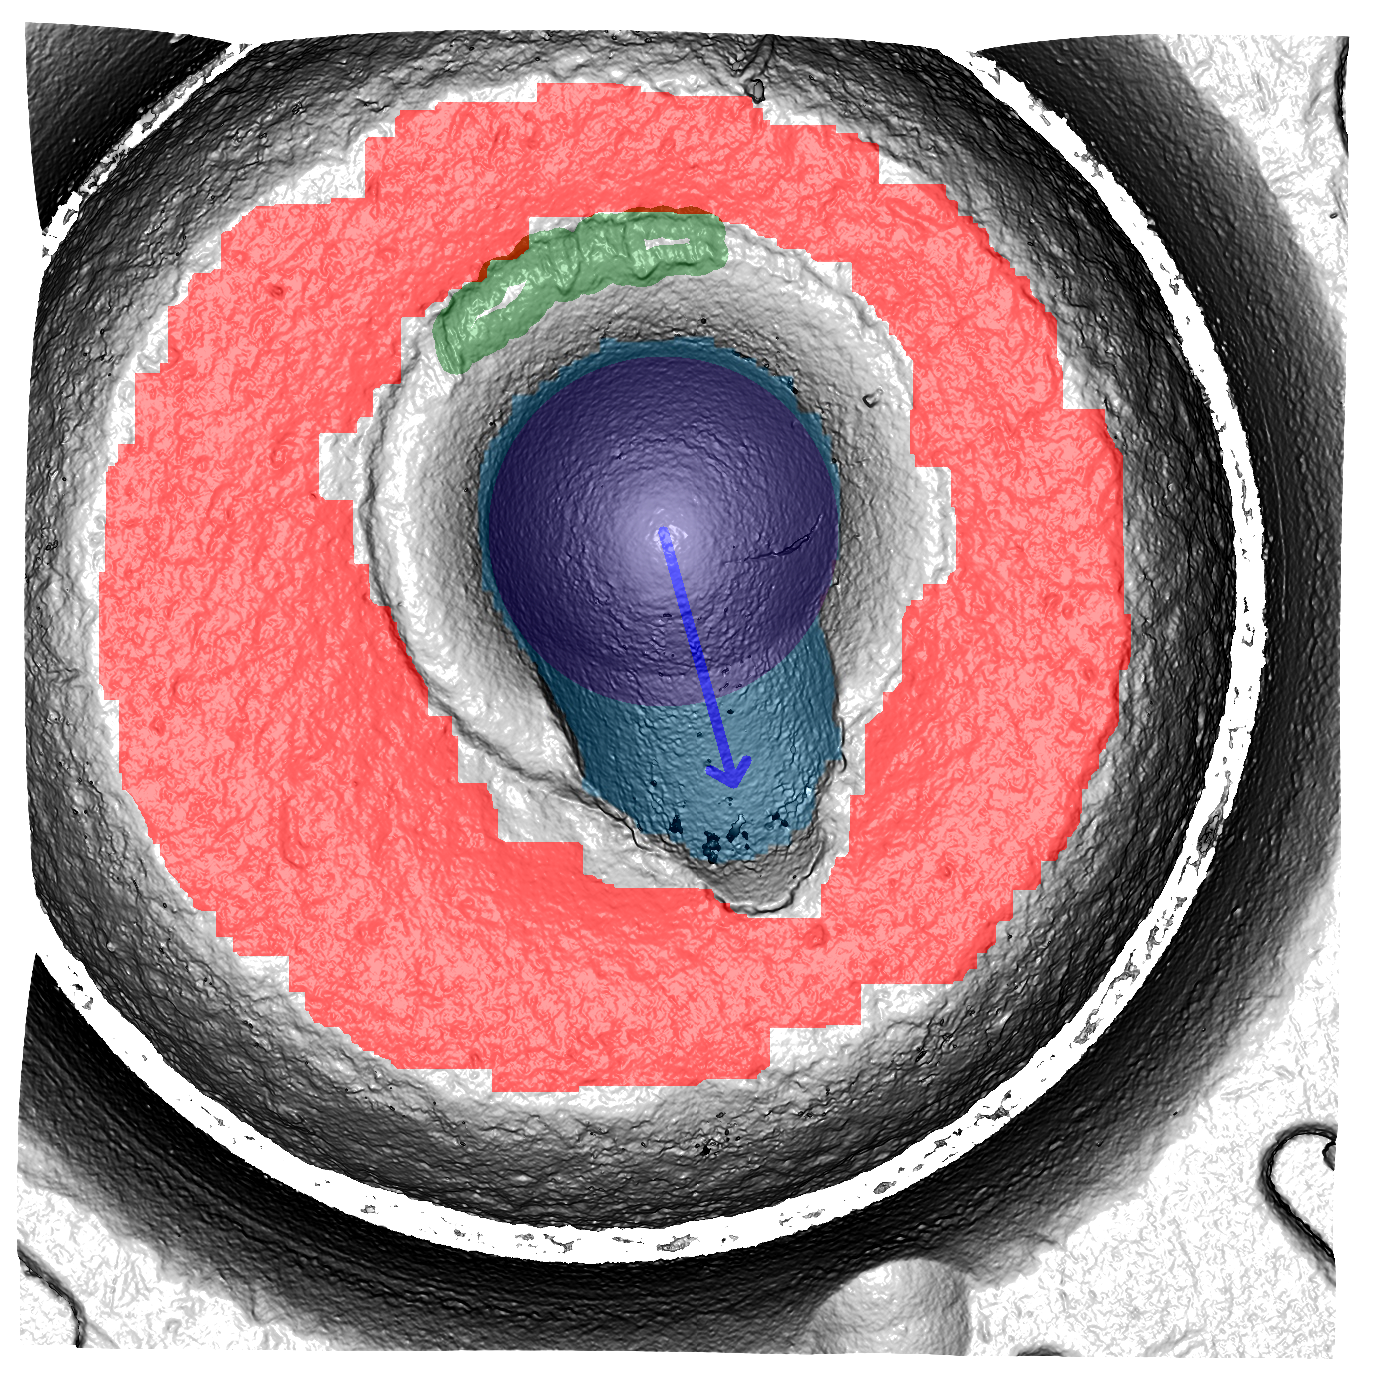

In [20]:
contrast.copy()